In [38]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.io import read_image
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.utils import make_grid
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset
from custom_neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir(os.path.abspath(""))

In [39]:
train_dataset = MNIST('.', train=True, transform=ToTensor())
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [40]:
test_dataset = MNIST('.', train=False, transform=ToTensor())
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ToTensor()

In [41]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [62]:
iterdata = iter(train_dataset)
image, label = next(iterdata)
image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [63]:
display(ToPILImage()(image))

In [44]:
label

5

In [73]:
iterdata = iter(train_dataset)
for  i in range(5):
    image, label = next(iterdata)
    display(ToPILImage()(image))

In [77]:
# ToPILImage()(image).save('9f.png')

In [45]:
len(train_dataset)

60000

In [46]:
input_shape = image.shape
input_shape

torch.Size([1, 28, 28])

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [48]:
train_dataloader

Shape for a batch of N images of size HxW and having C channels (dim of a pixel, 3 if RGB, 1 if grayscale): (N, C, H, W)

In [49]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=16, out_features=120, bias=True)
    (7): ReLU()
    (8): Linear(in_features=120, out_features=84, bias=True)
    (9): ReLU()
    (10): Linear(in_features=84, out_features=10, bias=True)
    (11): LogSoftmax(dim=1)
  )
)

In [50]:
loss_fn = nn.NLLLoss()
loss_fn

NLLLoss()

In [51]:
optimizer = SGD(model.parameters(), lr=2e-2)
scheduler = ExponentialLR(optimizer, gamma=0.98)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.02
    lr: 0.02
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [52]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    n_batches = len(dataloader)
    n_print_per_batch = 4
    print_batches = np.arange(n_batches, step=n_batches/n_print_per_batch).astype(int) + 1
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_hat = model(X)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch in print_batches:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    scheduler.step()
    print(f"lr: {optimizer.param_groups[0]['lr']:.3f}")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    n_batches = len(dataloader)
    model.eval()
    test_loss, test_accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            test_loss += loss_fn(y_hat, y).item()
            test_accuracy += (torch.argmax(y_hat, dim=1) == y).sum().item()
    test_loss /= n_batches
    test_accuracy /= size
    return test_loss, test_accuracy

epochs = 50
test_losses = np.zeros((epochs,))
test_accuracies = np.zeros((epochs,))
for t in range(epochs):
    print(f"Epoch {t+1} -------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test_losses[t], test_accuracies[t] = test(test_dataloader, model, loss_fn)
    print(f"Test Error - Accuracy: {test_accuracies[t]:.2%} - Avg loss: {test_losses[t]:>8f} \n")
print("Done!")

Epoch 1 -------------------------------
Loss: 2.303307  [  512/60000]
Loss: 2.301068  [15360/60000]
Loss: 2.308255  [30464/60000]
Loss: 2.299296  [45568/60000]
lr: 0.020
Test Error - Accuracy: 11.35% - Avg loss: 2.300700 

Epoch 2 -------------------------------
Loss: 2.302403  [  512/60000]
Loss: 2.300362  [15360/60000]
Loss: 2.302451  [30464/60000]
Loss: 2.302171  [45568/60000]
lr: 0.019
Test Error - Accuracy: 11.35% - Avg loss: 2.298452 

Epoch 3 -------------------------------
Loss: 2.299195  [  512/60000]
Loss: 2.304669  [15360/60000]
Loss: 2.301316  [30464/60000]
Loss: 2.295031  [45568/60000]
lr: 0.019
Test Error - Accuracy: 11.35% - Avg loss: 2.291094 

Epoch 4 -------------------------------
Loss: 2.285220  [  512/60000]
Loss: 2.283612  [15360/60000]
Loss: 2.281581  [30464/60000]
Loss: 2.265280  [45568/60000]
lr: 0.018
Test Error - Accuracy: 48.54% - Avg loss: 2.230030 

Epoch 5 -------------------------------
Loss: 2.224291  [  512/60000]
Loss: 2.157405  [15360/60000]
Loss: 1.

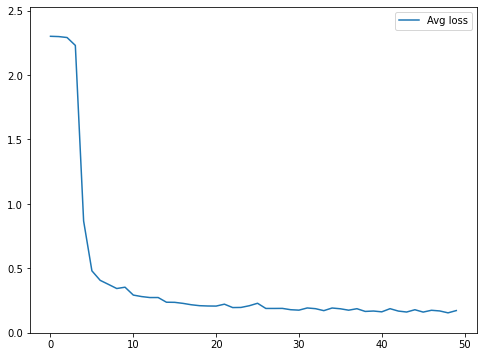

In [53]:
_, ax = plt.subplots(figsize=(8, 6))
plt.plot(test_losses, label='Avg loss')
ax.set_ylim(ymin=0, ymax=np.max(test_losses)*1.1)
ax.legend()
plt.savefig('loss.png')
plt.show()

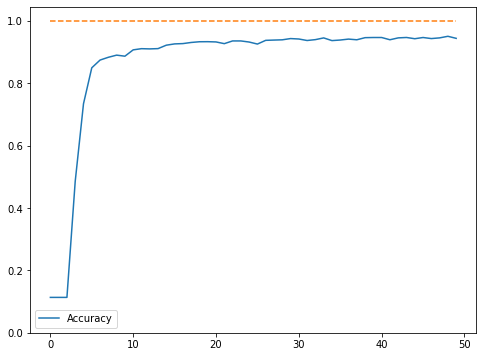

In [54]:
_, ax = plt.subplots(figsize=(8, 6))
plt.plot(test_accuracies, label='Accuracy')
plt.plot([0, len(test_accuracies)-1], [1, 1], '--')
ax.set_ylim(ymin=0, ymax=np.max(test_accuracies)*1.1)
ax.legend()
plt.savefig('accuracy.png')
plt.show()

In [55]:
torch.save(obj=model.state_dict(), f='model.pt')

In [56]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("torchlogs/")
writer.add_graph(model, image)
writer.close()
# Then navigate to the log directory from the shell and launch:
# tensorboard --logdir=./

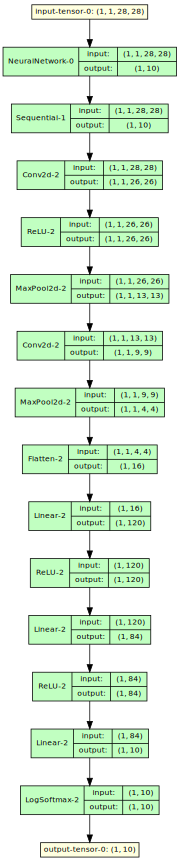

In [57]:
from torchview import draw_graph
batch_size = 1
model_graph = draw_graph(model, input_size=(batch_size, 1, 28, 28))
model_graph.visual_graph

In [58]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

cnn1.0.weight 	 torch.Size([1, 1, 3, 3])
cnn1.0.bias 	 torch.Size([1])
cnn1.3.weight 	 torch.Size([1, 1, 5, 5])
cnn1.3.bias 	 torch.Size([1])
cnn1.6.weight 	 torch.Size([120, 16])
cnn1.6.bias 	 torch.Size([120])
cnn1.8.weight 	 torch.Size([84, 120])
cnn1.8.bias 	 torch.Size([84])
cnn1.10.weight 	 torch.Size([10, 84])
cnn1.10.bias 	 torch.Size([10])
